#   Bibliotecas

- Versões das bibliotecas no README

In [1]:
import pandas as pd
import random 
import numpy as np
import re
from scipy.sparse import hstack #utilizada para a junção de matrizes

In [2]:
#Pré processamento de colunas

from sklearn.model_selection import train_test_split #Divisão do dataset entre treino e teste
from sklearn.feature_extraction.text import TfidfVectorizer #vetorização do dataset
from sklearn.preprocessing import OneHotEncoder #aplicação de dummy

In [3]:
#Pré processamento de texto


import nltk
from nltk import word_tokenize #tokenizador
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords   #stopword

nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
#import de funções do script de pre_processamento

from pre_processamento import pre_processamento, text_preprocess, textcolumns_junct,stemming

In [5]:
# Modelo a ser testado

from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.keras.metrics import RootMeanSquaredError

In [6]:
#metricas

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [7]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

# train = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\train.tsv", sep='\t')
train = pd.read_pickle("/content/drive/MyDrive/Datasets/train.pkl") 
test = pd.read_csv('/content/drive/MyDrive/Datasets/test.tsv', sep = '\t')

Mounted at /content/drive


In [8]:
# train,test = pre_processamento(train,test)

#   Pré-processamento 

In [9]:
# train = textcolumns_junct(train) #Função pra juntar as colunas de texto em uma só coluna

In [10]:
#Convertendo tudo para string

# train["item_description"] = train["item_description"].astype(str)

In [11]:
# train["item_description"] = train["item_description"].apply(lambda x: text_preprocess(x)) #Limpando texto com regex.

In [12]:
# train["item_description"] = train["item_description"].apply(lambda x: word_tokenize(x)) #tokenizando

In [13]:
# train["item_description"] = train["item_description"].apply(lambda x: stemming(x))

In [14]:
# train["item_description"]=[" ".join(review) for review in train["item_description"].values]

In [15]:
# train["item_description"]

In [16]:
train.shape

(1481661, 11)

#   Split

In [17]:
train1 = train.drop(train[~((train['price'] > 0) & (train['price'] <= 250))].index)

In [18]:
train1.shape

(1475534, 11)

In [19]:
X = train1.drop("price", axis = 1)
y = train1["price"]

In [20]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de teste de possíveis vazamentos e das mudanças de hyperparametros. 

X1, Xtest, y1, ytest = train_test_split(X, y, test_size=0.1, random_state=10) #Divisão em 90/10

In [21]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de validação de possíveis vazamentos. 

Xtrain, Xval, ytrain, yval = train_test_split(X1, y1, test_size=0.2, random_state=10) #Divisão em 80/20

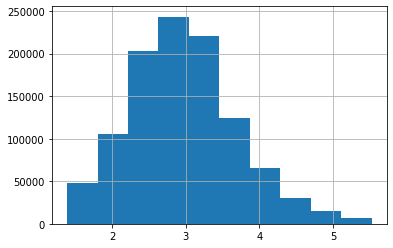

In [22]:
#Normalizando, com log, o target (price), foi realizado de forma separada para nao terem dados vazados.

ytrain =  np.log1p(ytrain)
ytrain.hist()

In [23]:
print(Xtrain.shape,ytrain.shape) 
print(Xval.shape,yval.shape)
print(Xtest.shape,ytest.shape)

(1062384, 10) (1062384,)
(265596, 10) (265596,)
(147554, 10) (147554,)


# Transformadores

In [24]:
vec = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), max_features=50000) #vetorização, com stop word. 

In [25]:
vec_train = vec.fit_transform(Xtrain["item_description"])

vec_train

<1062384x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 28444564 stored elements in Compressed Sparse Row format>

In [26]:
vec_val = vec.transform(Xval["item_description"])

vec_val

<265596x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 7105732 stored elements in Compressed Sparse Row format>

In [27]:
ohe = OneHotEncoder(handle_unknown="ignore")

#aplicação dummy nas colunas categóricas.

ohe_train = ohe.fit_transform(Xtrain[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])
                            
ohe_train

<1062384x985 sparse matrix of type '<class 'numpy.float64'>'
	with 5311920 stored elements in Compressed Sparse Row format>

In [28]:
ohe_val = ohe.transform(Xval[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])

ohe_val

<265596x985 sparse matrix of type '<class 'numpy.float64'>'
	with 1327960 stored elements in Compressed Sparse Row format>

In [29]:
#juntando cada matrix gerada por cada pré-processamento

x_train = hstack([
                 (vec_train),
                 (ohe_train)
                            ], format='csr') 
x_train

<1062384x50985 sparse matrix of type '<class 'numpy.float64'>'
	with 33756484 stored elements in Compressed Sparse Row format>

In [30]:
x_val = hstack([
                 (vec_val),
                 (ohe_val)
                             ], format='csr') 
x_val

<265596x50985 sparse matrix of type '<class 'numpy.float64'>'
	with 8433692 stored elements in Compressed Sparse Row format>

# Modelo

In [31]:
input = Input(shape=(x_train.shape[-1]), sparse=True, name='sparse')
dense3 = Dense(1024, activation="relu") (input)
dense4 = Dense(512, activation="relu") (dense3)
dense5 = Dense(256, activation="relu") (dense4)
out = Dense(1) (dense5)

model = Model(inputs = input, outputs = out)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sparse (InputLayer)         [(None, 50985)]           0         
                                                                 
 dense (Dense)               (None, 1024)              52209664  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 52,866,049
Trainable params: 52,866,049
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(loss="mean_squared_error", metrics=['mean_squared_error', 'mean_squared_logarithmic_error', RootMeanSquaredError()], optimizer = 'Adam')
history1 = model.fit(x_train, ytrain.values, batch_size=2048, epochs=10, verbose=True)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


519/519 [==============================] - 31s 54ms/step - loss: 0.3163 - mean_squared_error: 0.3163 - mean_squared_logarithmic_error: 0.0267 - root_mean_squared_error: 0.5624
Epoch 2/10
519/519 [==============================] - 30s 54ms/step - loss: 0.1753 - mean_squared_error: 0.1753 - mean_squared_logarithmic_error: 0.0113 - root_mean_squared_error: 0.4187
Epoch 3/10
519/519 [==============================] - 30s 53ms/step - loss: 0.1285 - mean_squared_error: 0.1285 - mean_squared_logarithmic_error: 0.0083 - root_mean_squared_error: 0.3584
Epoch 4/10
519/519 [==============================] - 30s 53ms/step - loss: 0.0866 - mean_squared_error: 0.0866 - mean_squared_logarithmic_error: 0.0057 - root_mean_squared_error: 0.2942
Epoch 5/10
519/519 [==============================] - 30s 53ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - mean_squared_logarithmic_error: 0.0039 - root_mean_squared_error: 0.2415
Epoch 6/10
519/519 [==============================] - 33s 59ms/step - loss: 

In [33]:
ypredict = model.predict(x_val)

8300/8300 [==============================] - 20s 2ms/step


In [34]:
ypredict_train = model.predict(x_train)

33200/33200 [==============================] - 81s 2ms/step


In [35]:
ypredict = np.expm1(ypredict)
ypredict_train = np.expm1(ypredict_train)

#   Resultado

- predict validação

In [37]:
print('MAE: $ %.2f' %  mean_absolute_error(yval,ypredict))
print('RMSE:  $ %.2f' %  (mean_squared_error(yval,ypredict)**0.5))
print('RMSLE: %2f' % mean_squared_log_error(yval,ypredict))


MAE: $ 9.49
RMSE:  $ 18.45
RMSLE: 0.216088


- predict treino

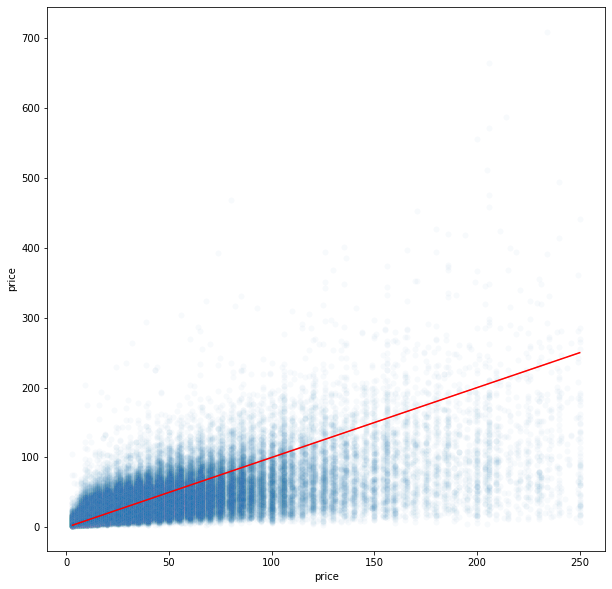

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.scatterplot(x=yval, y=[i[0] for i in ypredict.tolist()], alpha=0.03)

sns.lineplot(x=yval, y=yval, color='red')

In [44]:
print('MAE_train: $%2f' % mean_absolute_error(np.expm1(ytrain),np.expm1(ypredict_train)))
print('RMSE_train: $%2f' % (mean_squared_error(np.expm1(ytrain),np.expm1(ypredict_train))**0.5))
print('RMSLE_train: %2f' % mean_squared_log_error(np.expm1(ytrain),np.expm1(ypredict_train)))

MAE_train: $2.883080
RMSE_train: $6.748363
RMSLE_train: 0.017844


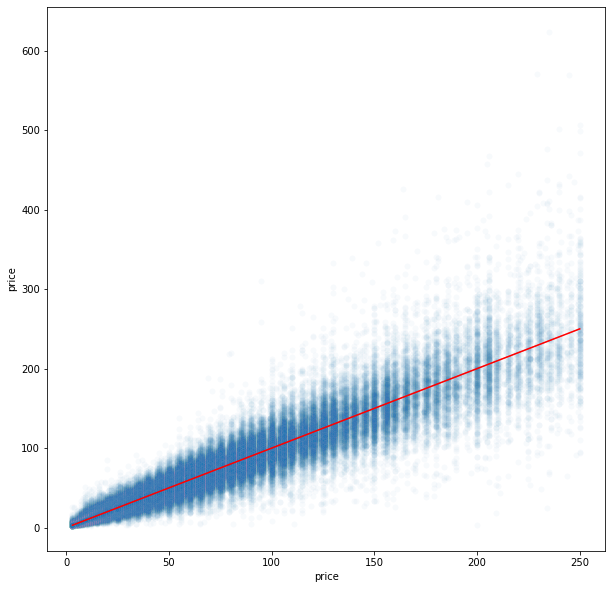

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.scatterplot(x=np.expm1(ytrain), y=[i[0] for i in np.expm1(ypredict_train).tolist()], alpha=0.03)

sns.lineplot(x=np.expm1(ytrain), y=np.expm1(ytrain), color='red')